In [2]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
import io
import requests 
from bs4 import BeautifulSoup
import time
from matplotlib.lines import Line2D
import os
import csv
from os import listdir
from scipy import ndimage
from scipy import stats
from scipy import signal
from HPGe import *

In [3]:
marker_list = list(Line2D.markers.keys())

In [4]:
Spectra().df

,Filename,Live time/s,Real time/s,Total CPS
0,Background_16_10_23_Mon_14_50.csv,353069.86,354394.61,1.041791
1,HPGe_21.02.2022_background.csv,1204602.50,1209121.82,2.596276
2,HPGe_Background_12.12.23.csv,411527.06,413117.24,1.946662
3,HPGe_Sample3_07.12.23.csv,777953.97,780963.11,0.447947
4,IAEA_Sample_20_11_23_Mon_10_58.csv,589490.43,591717.78,0.668286
5,IAEA_sample_05.12.22 copy.csv,1191067.75,1195547.14,4.114920
6,Sample1_23_10_23_Mon_10_39.csv,586551.55,588791.75,4.144091
7,Sample2_31_10_23_14_08.csv,690516.01,693190.81,4.447199
8,Sample3_07_11_23_Tue_11_50.csv,592161.76,594479.48,2.488062
9,Sample4_13_11_23_Mon_14_06.csv,523881.40,525880.09,4.665623


In [5]:
sample_df = pd.DataFrame(
{'Sample':[1,2,3,4,'IAEA-385'],
'Depth/cm':['0-10','10-20','20-30','30-40','--'],
'Beaker mass/kg':[0.0583,0.0576,0.0581,0.0581,0], 
'Gross mass/kg':[0.4279,0.5733,0.5399,0.5585,0]})
sample_df['Net mass/kg'] = sample_df['Gross mass/kg'] - sample_df['Beaker mass/kg']
sample_df.loc[4,'Net mass/kg'] =0.05
print(sample_df.to_latex(index = False,column_format = 'c|c|c|c|c'))
list(sample_df['Net mass/kg'])

\begin{tabular}{c|c|c|c|c}
\toprule
  Sample & Depth/cm &  Beaker mass/kg &  Gross mass/kg &  Net mass/kg \\
\midrule
       1 &     0-10 &          0.0583 &         0.4279 &       0.3696 \\
       2 &    10-20 &          0.0576 &         0.5733 &       0.5157 \\
       3 &    20-30 &          0.0581 &         0.5399 &       0.4818 \\
       4 &    30-40 &          0.0581 &         0.5585 &       0.5004 \\
IAEA-385 &       -- &          0.0000 &         0.0000 &       0.0500 \\
\bottomrule
\end{tabular}



/var/folders/vh/bwtbn9cn1xlbm74kxlygt5b80000gn/T/ipykernel_94112/3254177405.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(sample_df.to_latex(index = False,column_format = 'c|c|c|c|c'))


[0.3696, 0.5157, 0.48180000000000006, 0.5004, 0.05]

In [6]:
def err_prop(data,err):
    '''Error propagation for effect of rescaling sample 3 data'''
    S_err_S = Spec(3).S_err/Spec(3).S
    err_data = err/data
    return data*Spec(3).S * np.sqrt(S_err_S**2 + err_data**2)

In [104]:
print('scaling factor and its error',Spec(3).S,Spec(3).S_err)

scaling factor and its error 1.9002867527141494 0.05437774972003003


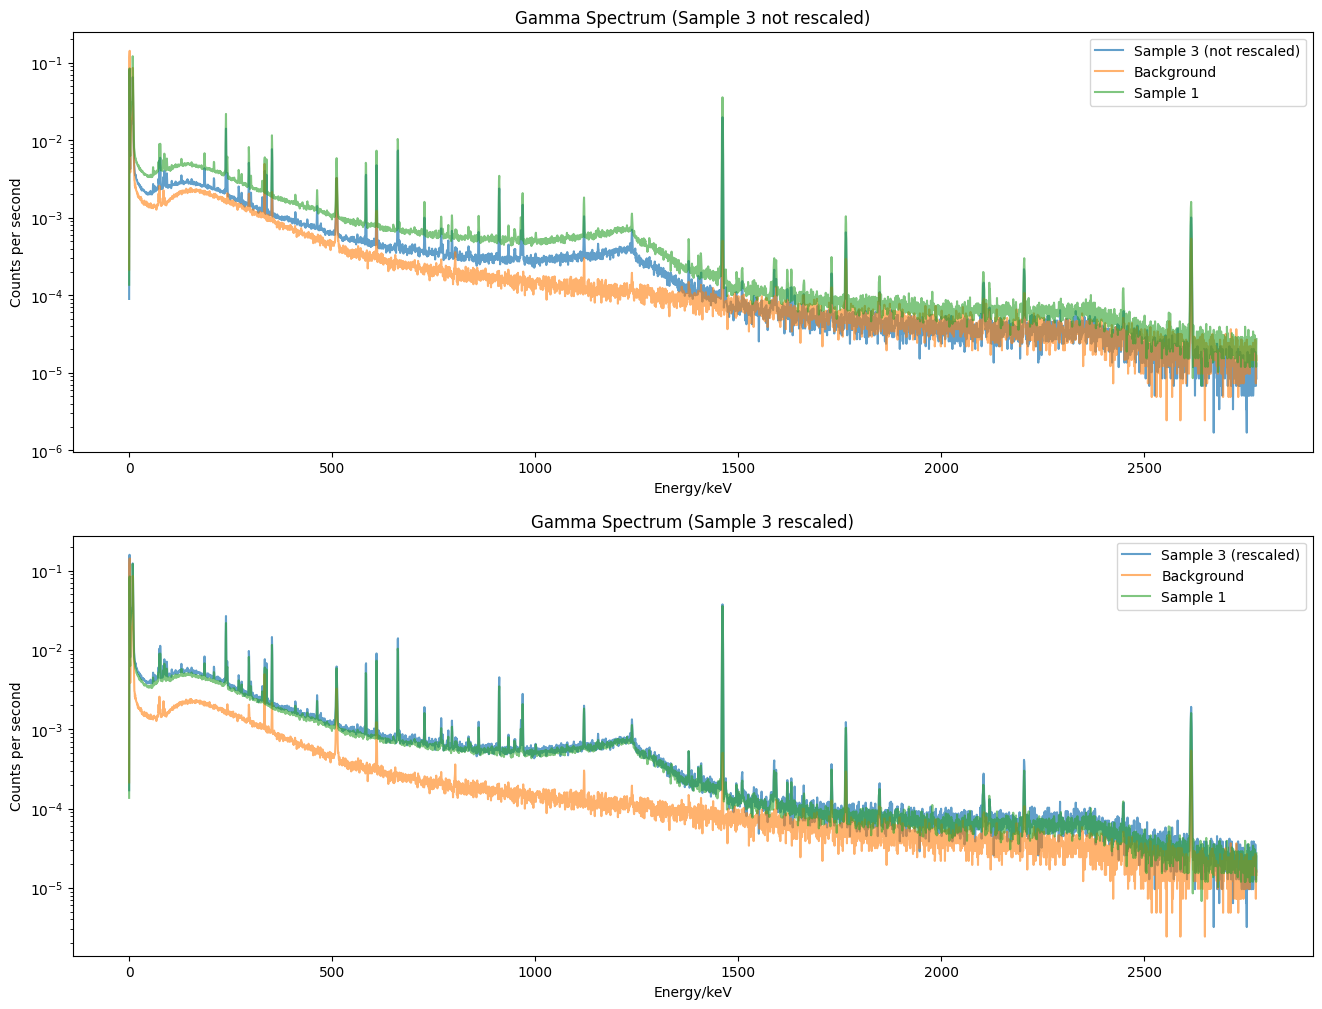

In [7]:
label_list = ['Background', 'Sample 1', 'Sample 2', 'Sample 3', 'Sample 4','IAEA-385']
fig, ax = plt.subplots(nrows = 2, ncols = 1,figsize= (16,12))
ax[0].set_title('Gamma Spectrum (Sample 3 not rescaled)')
ax[1].set_title('Gamma Spectrum (Sample 3 rescaled)')
ax[0].plot(Spec(3).E,Spec(3).cps/Spec(3).S,alpha = 0.7,label = 'Sample 3 (not rescaled)')
ax[1].plot(Spec(3).E,Spec(3).cps,alpha = 0.7,label = 'Sample 3 (rescaled)') 
for n in range(2):
    for i in [0,1]:
        ax[n].plot(Spec(i).E,Spec(i).cps,label=label_list[i],alpha = 0.6)
    ax[n].legend()
    ax[n].set_ylabel('Counts per second')
    ax[n].set_xlabel('Energy/keV')
    ax[n].set_yscale('log')
plt.savefig('Plot Images/sample3_rescale.pdf')

### Am241 ingrowth correction

When a parent decays into the daughter nuclide, rate of cahnge of daughter atoms is the difference between rate of growth from parent and rate of decay of itself. Solving the differential equation 
$$\frac{dN_D}{dt} = -\lambda_D N_D+\lambda_P N_P$$ 
gives
$$ A_D = \frac{\lambda_D}{\lambda_D-\lambda_P} A_{P0}(e^{-\lambda_P t}-e^{-\lambda_D t})+A_{D0}e^{-\lambda_D t}$$
$D, P$ denotes daughter and parent respectively. Initial activityies are  $A_{D0}, A_{P0}$. $A = \lambda N$

corrected: $4.45 \pm 0.23$ Bq/kg 


In [8]:
lambda_D = np.log(2)/1.365e10
lambda_P = np.log(2)/4.51e8  
time_string = "1 January, 2019"
ref = time.strptime(time_string, "%d %B, %Y") #time_struct object of decay correction reference date
now = time.strptime("5 December, 2022", "%d %B, %Y")
dt = time.mktime(now)-time.mktime(ref) #time (in seconds) passed
#initial certified activity of IAEA385 on 1/1/2019

def ingrowth(A_D0,A_P0,A_D0_err,A_P0_err,lambda_D ,lambda_P):
    A_D = lambda_D/(lambda_D-lambda_P)*A_P0*(np.exp(-lambda_P*dt)-np.exp(-lambda_D*dt)) + A_D0*np.exp(-lambda_D*dt)
    A_D_err = np.sqrt((lambda_D/(lambda_D-lambda_P)*(np.exp(-lambda_P*dt)-np.exp(-lambda_D*dt))*A_P0_err)**2
                 +(A_D0_err*np.exp(-lambda_D*dt))**2)
    return [A_D, A_D_err]
A_D0 = 4.42
A_P0 = 9.9
A_D0_err = 0.23
A_P0_err = 1


print('corrected Am241 activity', ingrowth(A_D0,A_P0,A_D0_err,A_P0_err,lambda_D,lambda_P))
print('corrected R226 activity', ingrowth(22.8 ,31.8,0.6,1.4,np.log(2)/5.0492e10,np.log(2)/2.379e12 ) )

corrected Am241 activity [4.448810064073606, 0.22862881301554963]
corrected R226 activity [22.81529365549371, 0.5989850827837179]


### Create DataFrame of all peaks csv files of different spectra
Order: background (12/12/2023), samples 1-4, IAEA385 (2022)

In [9]:
pk_path_ls = sorted(listdir('Data/Peaks_final'))[1:] #peak csv path list
#concat all modified peak dataframe
pk_path_ls = [pk_path_ls[1]] + pk_path_ls[2:] + [pk_path_ls[0]] #reorder such that: bg, sample 1-4, iaea
df = pd.concat([peak_df_new(peak_df('Data/Peaks_final/'+path)) for path in pk_path_ls],keys = range(len(pk_path_ls)))
m_arr = [1]+list(sample_df['Net mass/kg'])
#rescale sample 3
df.loc[3,['Net_Area_Count','Peak_CPS','Peak_CPS_BR']] = df.loc[3,['Net_Area_Count','Peak_CPS','Peak_CPS_BR']].values * Spec(3).S
df.loc[3,'Net_Area_err'] = err_prop(df.loc[3,'Net_Area_Count'].values,df.loc[3,'Net_Area_err'].values) #error propagation
#correct Ra226 186.211keV line count rate
df.loc[df[df['nndc_peak_energy']==186.211].index,['Peak_CPS','Peak_CPS_BR']] *= 0.571
df['rel_err'] = df['Net_Area_err']/df['Net_Area_Count'] #relative error in area
df['Peak_CPS_BR_m'] = df['Peak_CPS_BR']/np.concatenate([np.full(len(df.loc[i]),m_arr[i])for i in range(6)]) #per mass

In [10]:
iaea_df = df.loc[5]
bg_df = df.loc[0]

In [34]:
#convert peak energy to channel number (fraction of channel number) using Lynx calibration
#Lynx calibration: energy = a * Ch^2 + b*Ch + c
a = 8.387880257e-8
b = 0.6775230169
c = -0.3439140022

energy_to_chan = lambda x : (-b + np.sqrt(b**2-4*a*(c-x)))/2/a #quadratic formula

358.3688458393056

In [131]:
Spec(5)

IndexError: index 4 is out of bounds for axis 0 with size 4

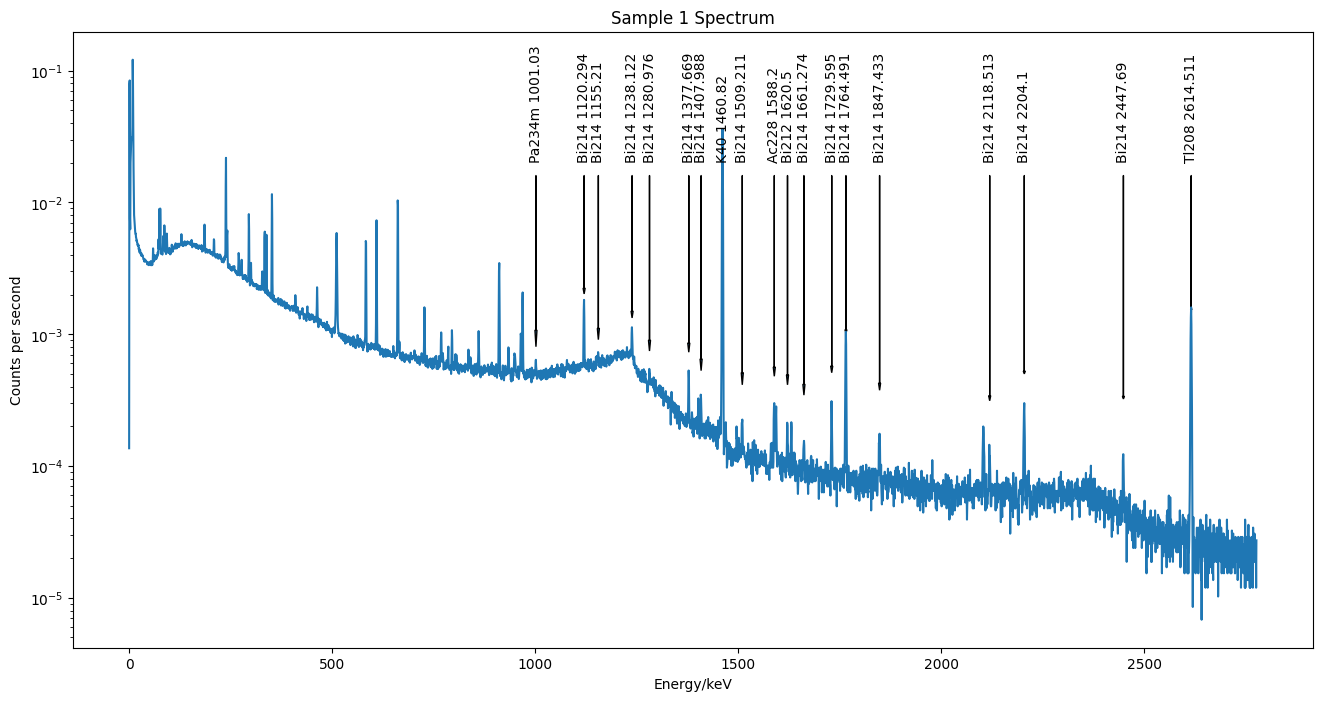

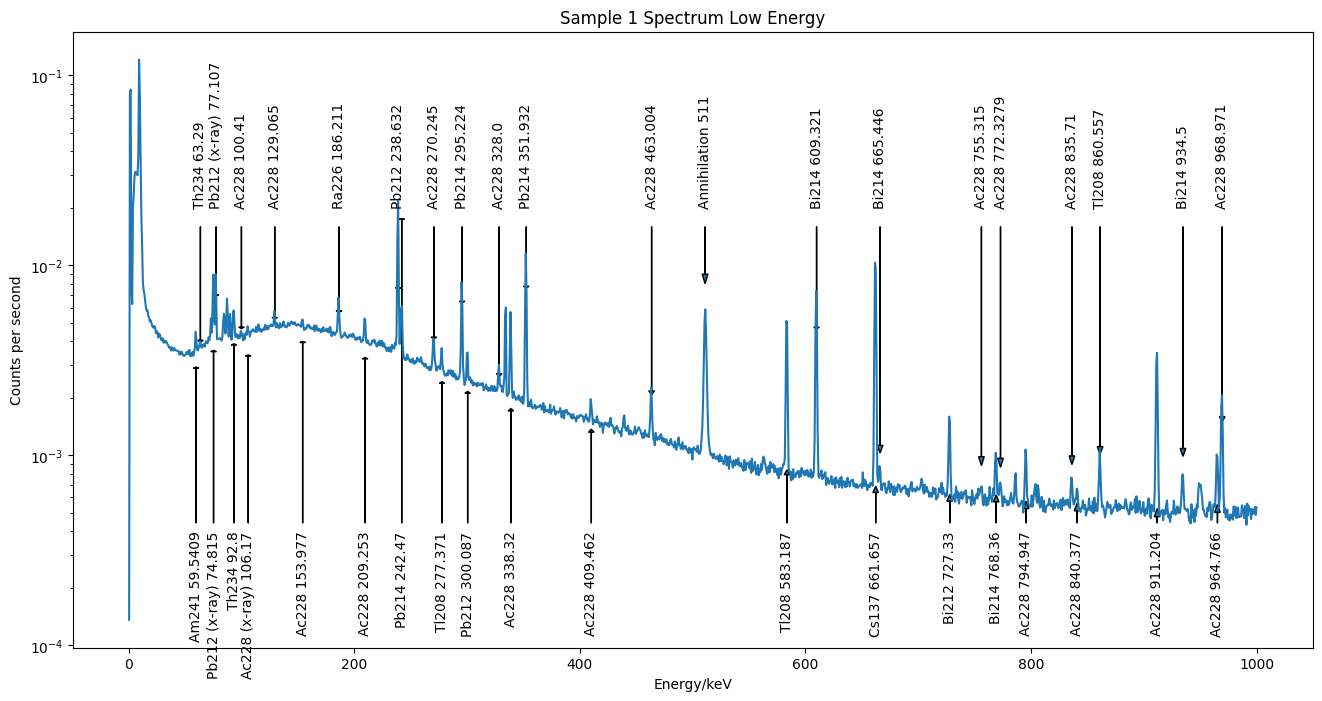

In [130]:
for i in range(1,5):
    plt.figure(figsize = (16,8))
    plt.yscale('log')
    plt.plot(Spec(i).E,Spec(i).cps)
    for index, row in  df.loc[i].iterrows():
        idx = int(energy_to_chan(row['nndc_peak_energy']))
        if row['Centroid'] > 1000 and row['nndc_peak_energy'] != 1630.627 :
            y_text = 0.02
            plt.text(row['Centroid'],y_text,
            row['Nuclide']+' '+str(row['nndc_peak_energy']), 
            horizontalalignment='center',
            verticalalignment='bottom',
                rotation='vertical')
            plt.arrow(row['Centroid'],0.8*y_text,0,Spec(i).cps[idx]-0.79*y_text,
            length_includes_head=True,head_width=5,head_length=np.exp(-row['Centroid']/500)*y_text*0.1)
    plt.ylabel('Counts per second')
    plt.xlabel('Energy/keV')
    plt.title(f'{label_list[i]} Spectrum')
    plt.figure(figsize = (16,8))
    plt.yscale('log')
    plt.plot(Spec(i).E[Spec(i).E<1000],Spec(i).cps[Spec(i).E<1000])
    for index, row in  df.loc[i].iterrows():
        idx = int(energy_to_chan(row['Centroid']))
        # if row['Centroid'] < 1000 and  row['Centroid'] > 106:
        #     y_text = 0.02
        #     plt.text(row['Centroid'],y_text,
        #     row['Nuclide']+' '+str(row['nndc_peak_energy']), 
        #     horizontalalignment='center',
        #     verticalalignment='bottom',
        #         rotation='vertical')
        #     plt.arrow(row['Centroid'],0.8*y_text,0,Spec(i).cps[idx]-0.79*y_text,
        #     length_includes_head=True,head_width=5,head_length=np.exp(-row['Centroid']/500)*y_text*0.1)
        if row['Centroid'] < 1000:
            tb = int((1+(-1)**index)/2) #1 or 0 when index is even or odd
            y_text = [0.02,0.0004][tb]
            plt.text(row['Centroid'],y_text,
            row['Nuclide']+' '+str(row['nndc_peak_energy']), 
            horizontalalignment='center',
            verticalalignment=['bottom','top'][tb],
                rotation='vertical')
            plt.arrow(row['Centroid'],[0.8,1.1][tb]*y_text,0,[Spec(i).cps[idx]-0.0158,(Spec(i).cps[idx-5]-y_text)*0.8][tb],
            length_includes_head=True,head_width=5,head_length=[0.0001,0.00005][tb])
    plt.text(511,0.02,
            'Annihilation 511', 
            horizontalalignment='center',
            verticalalignment='bottom',
                rotation='vertical')
    plt.arrow(511,0.02*0.8,0,0.008-0.02*0.8,
            length_includes_head=True,head_width=5,head_length=0.001)
    plt.ylabel('Counts per second')
    plt.xlabel('Energy/keV')
    plt.title(f'{label_list[i]} Spectrum Low Energy')

In [107]:
for index, row in  df.loc[i].iterrows():
    idx = int(energy_to_chan(row['Centroid']))
    print(row['Net_Area_Count'])

934.2
305.0
4677.4
4856.8
2121.3
306.8
325.3
794.3
393.6
2959.6
1713.3
19128.6
4683.7
1868.1
931.9
6301.6
1350.3
992.4
3959.2
11260.1
525.9
1313.8
6295.1
8376.2
14436.6
309.8
1450.2
182.8
703.2
248.5
712.9
278.0
173.4
709.8
4540.8
502.3
864.2
2403.8
241.8
2095.3
178.0
835.2
177.1
511.8
253.6
65619.2
217.9
400.3
224.4
199.3
143.4
402.4
1966.3
297.0
164.9
572.7
180.1
3741.8


### Efficiency Calibration using IAEA385 Sample

In [12]:
#Cs activity is corrected for half life
iaea_385 =pd.read_csv('IAEA385_ReferenceActivity_2019.csv',delimiter = ',') 
iaea_mass = 0.05 #kg
#merge activity to iaea peak df
iaea_df = df.loc[5].merge(iaea_385,on='Nuclide')
#peak background correction
#merge peak background dataframe with iaea peak dataframe
iaea_df = iaea_df.merge(df.loc[0][['nndc_peak_energy','Peak_CPS_BR','rel_err']], on = 'nndc_peak_energy', 
how = 'left', suffixes = ['','_bg']) #df.loc[0] contains background peaks
iaea_df.loc[:,'Peak_CPS_BR_bg'].fillna(0,inplace = True)
#corrected count per sec/BR
iaea_df['Peak_CPS_BR_corr'] = iaea_df['Peak_CPS_BR']-iaea_df['Peak_CPS_BR_bg']
iaea_df['Peak_CPS_BR_corr_err'] = np.sqrt((iaea_df['Peak_CPS_BR']*iaea_df['rel_err'])**2
                                    +(iaea_df['Peak_CPS_BR_bg']*iaea_df['rel_err_bg'])**2)
iaea_df['eff'] = iaea_df['Peak_CPS_BR_corr']/(iaea_df['Abs_Activity']*iaea_mass) #efficiency
# #correction for composite peak at 186.211 (Gilmore p.321)
# Ra226_index = iaea_df[iaea_df['nndc_peak_energy']==186.211].index
# iaea_df.loc[Ra226_index,'eff'] *= 0.571
#error propagation (assume poisson noise for peak cps error)
iaea_df['eff_err']=iaea_df['eff']* np.sqrt((iaea_df['Net_Area_err']/iaea_df['Net_Area_Count'])**2+
(iaea_df['Abs_Activity_Unc']/iaea_df['Abs_Activity'])**2 + 0.05**2) #0.05**2 from percentage error of mass

df = pd.concat([df.loc[i].merge(iaea_df[['nndc_peak_energy','Peak_CPS_BR_bg','rel_err_bg']],on = 'nndc_peak_energy',how = 'left')
      for i in range(len(pk_path_ls))],keys = range(len(pk_path_ls)))
df.fillna(0,inplace = True)

In [425]:
U235_U238_ratio_iaea = 0.007/0.993
U235_U238_ratio_nndc =0.7204/99.2742
print(U235_U238_ratio_iaea,U235_U238_ratio_nndc)

0.007049345417925478 0.007256668902897229


In [393]:
iaea_df['nndc_peak_energy'].unique()

array([  59.5409,   63.29  ,   92.8   ,  100.41  ,  129.065 ,  153.977 ,
        209.253 ,  270.245 ,  328.    ,  332.37  ,  338.32  ,  409.462 ,
        463.004 ,  755.315 ,  772.3279,  794.947 ,  835.71  ,  840.377 ,
        911.204 ,  964.766 ,  968.971 , 1588.2   , 1630.627 ,  186.211 ,
        238.632 ,  300.087 ,  242.47  ,  295.224 ,  351.932 ,  277.371 ,
        583.187 ,  860.557 , 2614.511 ,  609.321 ,  665.446 ,  768.36  ,
        934.5   , 1120.294 , 1155.21  , 1238.122 , 1280.976 , 1377.669 ,
       1407.988 , 1509.211 , 1661.274 , 1729.595 , 1764.491 , 1847.433 ,
       2118.513 , 2204.1   , 2447.69  ,  661.657 ,  727.33  , 1620.5   ,
       1460.82  ])

efficiency fit parameters: [-2.44591423e+04  4.04578570e+02 -4.04548974e+00 -2.21065474e-04]
efficiency fit parameters errors: [2.09044357e+03 4.18226030e+01 1.43782120e-01 8.83965742e-05]


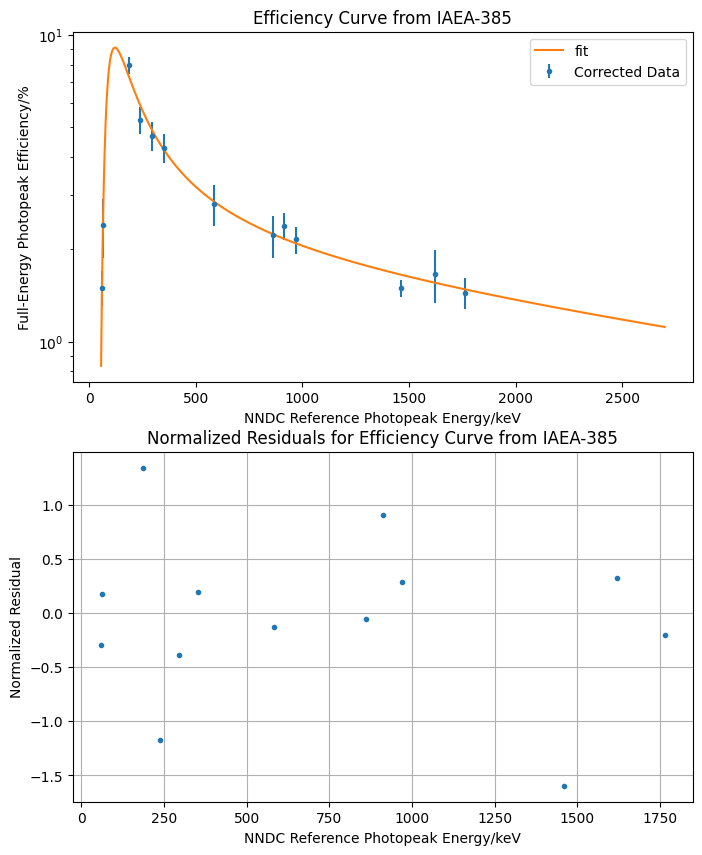

In [13]:
def eff_fit(x,a,b,c,d):
    '''Efficiency fit function
       x: energy (independent variable)
       p: parameter array
       this form of equation is suggested in Gilmore p.193'''
    return d*x+np.poly1d([a,b,c])(1/x)
    
U238_E = [63.29, 1001.030, 186.211,351.932 ,295.224, 1764.491 ]
Th232_E = [ 911.204 ,  968.971 , 238.632, 1620.5,583.187,860.557]
eff_df = iaea_df[iaea_df['nndc_peak_energy'].isin(U238_E+Th232_E+[59.5409,1460.82])]
x_eff = eff_df['nndc_peak_energy']
eff_par, eff_cov = curve_fit(eff_fit,x_eff,np.log(eff_df['eff']))
eff_par_err = np.sqrt(np.diag(eff_cov))
print('efficiency fit parameters:', eff_par)
print('efficiency fit parameters errors:',eff_par_err)

fig, ax = plt.subplots(nrows =2, ncols =1,figsize = (8,10))

ax[0].set_title('Efficiency Curve from IAEA-385')
ax[0].errorbar(x_eff,100*eff_df['eff'],yerr =100*eff_df['eff_err'], fmt = '.',label = 'Corrected Data')
#ax[0].errorbar(x_eff,100*eff_df['Peak_CPS_BR']/(eff_df['Abs_Activity']*iaea_mass),yerr =100*eff_df['eff_err'], fmt = 'x',label = 'Original Data')
ax[0].plot(np.linspace(55,2700,10000),100*np.exp(eff_fit(np.linspace(55,2700,10000),*eff_par)),label = 'fit')
ax[0].set_xlabel('NNDC Reference Photopeak Energy/keV')
ax[0].set_ylabel('Full-Energy Photopeak Efficiency/%')
#plt.xscale('log')
ax[0].set_yscale('log')
ax[0].legend()

ax[1].set_title('Normalized Residuals for Efficiency Curve from IAEA-385')
ax[1].plot(x_eff,(eff_df['eff']-np.exp(eff_fit(x_eff,*eff_par)))/eff_df['eff_err'],'.')
ax[1].set_xlabel('NNDC Reference Photopeak Energy/keV')
ax[1].set_ylabel('Normalized Residual')
ax[1].grid()

In [ ]:
# def eff_fit2(x,a,b,c):
#     '''Efficiency fit function
#        x: energy (independent variable)
#        p: parameter array
#        this form of equation is suggested in Gilmore p.193'''
#     return np.exp(np.poly1d([a,b,c])(1/x))
    
# U238_E = [63.29, 1001.030, 186.211,351.932 ,295.224, 1764.491 ]
# Th232_E = [ 911.204 ,  968.971 , 238.632, 1620.5,583.187,860.557]
# eff_df = iaea_df[iaea_df['nndc_peak_energy'].isin(U238_E+Th232_E+[59.5409,1460.82])]
# x_eff = eff_df['nndc_peak_energy']
# eff_par2, eff_cov2 = curve_fit(eff_fit2,x_eff,eff_df['eff'],p0 = [0.001,0.01,0.1])
# eff_par_err2= np.sqrt(np.diag(eff_cov2))
# print('efficiency fit parameters:', eff_par2)
# print('efficiency fit parameters errors:',eff_par_err2)

# fig, ax = plt.subplots(nrows =2, ncols =1,figsize = (8,10))

# ax[0].set_title('Efficiency Curve from IAEA-385')
# ax[0].errorbar(x_eff,100*eff_df['eff'],yerr =100*eff_df['eff_err'], fmt = '.',label = 'Corrected Data')
# ax[0].errorbar(x_eff,100*eff_df['Peak_CPS_BR']/(eff_df['Abs_Activity']*iaea_mass),yerr =100*eff_df['eff_err'], fmt = 'x',label = 'Original Data')
# ax[0].plot(np.linspace(55,2700,10000),100*eff_fit2(np.linspace(55,2700,10000),*eff_par2),label = 'fit')
# ax[0].set_xlabel('NNDC Reference Photoeak Energy/keV')
# ax[0].set_ylabel('Full-Energy Photopeak Efficiency/%')
# #plt.xscale('log')
# ax[0].set_yscale('log')
# ax[0].legend()

# ax[1].set_title('Normalized Residuals for Efficiency Curve from IAEA-385')
# ax[1].plot(x_eff,(eff_df['eff']-eff_fit2(x_eff,*eff_par2))/eff_df['eff_err'],'.')
# ax[1].set_xlabel('NNDC Reference Photoeak Energy/keV')
# ax[1].set_ylabel('Normalized Residual')
# ax[1].grid()

In [15]:
eff_cov


array([[ 4.36995430e+06, -8.67372043e+04,  2.76211090e+02,
        -1.54121075e-01],
       [-8.67372043e+04,  1.74913013e+03, -5.72333400e+00,
         3.23115088e-03],
       [ 2.76211090e+02, -5.72333400e+00,  2.06732982e-02,
        -1.21861980e-05],
       [-1.54121075e-01,  3.23115088e-03, -1.21861980e-05,
         7.81395432e-09]])

Consider  a function $Z(x,a,b,c)$, where a,b,c are parameters to be fitted.
$$\sigma_Z^2(x) = v^T(x) C v(x)$$
where $v := [\partial_aZ|_x \ \partial_bZ|_x\  \partial_cZ|_x]^T$ and $C$ is the covariance matrix

In [14]:
df['eff'] = np.exp(eff_fit(df['nndc_peak_energy'],*eff_par))
#partial derivatives of efficiency function w.r.t parameters a, b, c
eff_d = df['eff']*df['nndc_peak_energy']
eff_c = df['eff']
eff_b = df['eff']/df['nndc_peak_energy']
eff_a = df['eff']/df['nndc_peak_energy']**2
partial_eff = np.array([eff_a,eff_b,eff_c,eff_d])
#variance of efficiency, calculatedusing covariance matrix 
#take the diagonal entries, as the vectors v should be evaluated at the same energy
df['eff_err'] = np.sqrt(np.diag(np.dot(partial_eff.T,np.dot(eff_cov,partial_eff))))

### Energy, $FWHM^2$ Calibration

In [30]:
#calibration dataframe (IAEA285)
cal_E = [ 270.245,  277.371,  
        351.932,  463.004,  583.187,  609.321,  661.657,  727.33 ,
        860.557,  911.204,  934.5  ,  1120.294,
       1238.122, 1377.669 , 1620.5  , 1630.627, 1729.595,
       1764.491, 1847.433, 2204.1 ]
cal_df = df.loc[5][df.loc[5]['nndc_peak_energy'].isin(cal_E)]


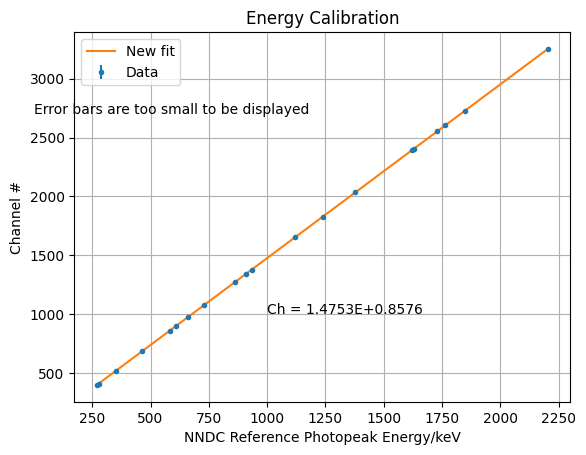

In [31]:
#convert peak energy to channel number (fraction of channel number) using Lynx calibration
#Lynx calibration: energy = a * Ch^2 + b*Ch + c
a = 8.387880257e-8
b = 0.6775230169
c = -0.3439140022

energy_to_chan = lambda x : (-b + np.sqrt(b**2-4*a*(c-x)))/2/a #quadratic formula


x = cal_df['nndc_peak_energy']
y = energy_to_chan(cal_df['Centroid'])
y_err = 1/np.sqrt(b**2-4*a*(c-x))*cal_df['Centroid_err']
E_par, E_cov = np.polyfit(x,y,1,cov = True) #energy callibration using peak
E_err= np.sqrt(np.diag(E_cov))
E_fit = np.poly1d(E_par)

#errorbars are too small to be displayed
plt.title('Energy Calibration')
plt.errorbar(x,y,yerr= y_err, fmt = '.',label = 'Data')
plt.plot(x,E_fit(x),label = 'New fit')
plt.legend()
plt.ylabel('Channel #')
plt.xlabel('NNDC Reference Photopeak Energy/keV')
plt.text(1000,1000,f'Ch = {E_par[0]:.4f}E+{E_par[1]:.4f}')
plt.text(1,2700,'Error bars are too small to be displayed')
plt.grid()

In [464]:
E_err

array([9.36143027e-05, 1.12643818e-01])

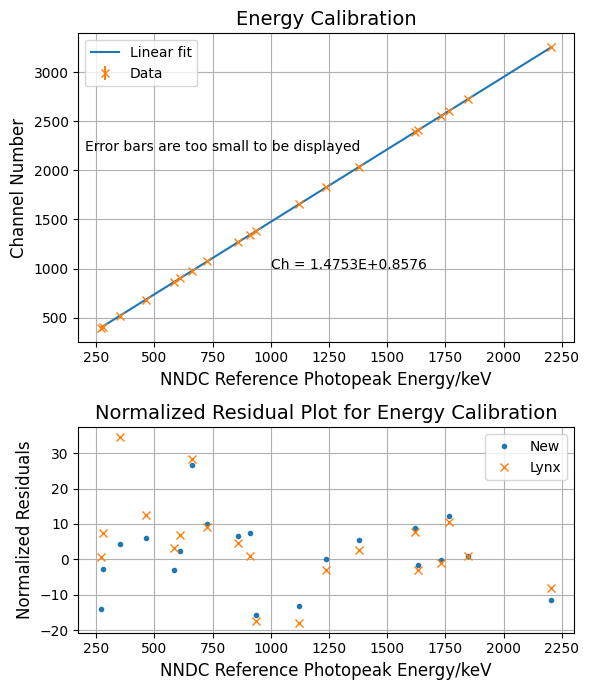

In [18]:
label_size = 12
title_size = 14
fig_E,ax_E = plt.subplots(2,1,figsize = (6,7), gridspec_kw={'height_ratios': [3, 2]})
ax_E[0].set_title('Energy Calibration',fontsize=title_size)
ax_E[0].plot(x,E_fit(x),label= 'Linear fit')
ax_E[0].errorbar(x,y,yerr= y_err, fmt = 'x',label = 'Data')
ax_E[0].text(1000,1000,f'Ch = {E_par[0]:.4f}E+{E_par[1]:.4f}')
ax_E[0].text(200,2200,'Error bars are too small to be displayed')
ax_E[0].set_xlabel('NNDC Reference Photopeak Energy/keV',fontsize=label_size)
ax_E[0].set_ylabel('Channel Number',fontsize=label_size)
ax_E[0].grid()
ax_E[0].legend()
ax_E[1].set_title('Normalized Residual Plot for Energy Calibration',fontsize=title_size)
ax_E[1].plot(x,(y-E_fit(x))/y_err,'.',label= 'New')
ax_E[1].plot(x,(y-energy_to_chan(x))/y_err,'x',label = 'Lynx')
ax_E[1].set_xlabel('NNDC Reference Photopeak Energy/keV',fontsize=label_size)
ax_E[1].set_ylabel('Normalized Residuals',fontsize=label_size)
ax_E[1].grid()
ax_E[1].legend()
fig_E.tight_layout()
# ax[1].set_title('Residual Plot for Energy Calibration')
# ax[1].plot(x,(y-E_fit(x)),'.',label= 'New')
# ax[1].plot(x,(y-energy_to_chan(x)),'x',label = 'Lynx')
# ax[1].set_xlabel('NNDC Reference Photopeak Energy/keV')
# ax[1].set_ylabel('Residuals')
# ax[1].grid()
# ax[1].legend()
plt.savefig('formal_report_plots/E_cal.pdf')

In [335]:
chi2_prob(energy_to_chan(x),y,y_err,len(y)-2)
chi2_prob(E_fit(x),y,y_err,len(y)-2)

 chi2: 3281.3526423985977 
 reduced chi2: 182.29736902214432
 chi2 p-value: 0.0
 chi2: 1998.30163458905 
 reduced chi2: 111.01675747716945
 chi2 p-value: 0.0


111.01675747716945

In [276]:
C_E_par = [1/E_par[0],-E_par[1]/E_par[0]] #channel to energy linear fit coefficients m,c: E = m*Ch+c
C_E_err = [E_err[0]/E_par[0]**2,abs(C_E_par[1]*np.sqrt(np.sum((E_err/E_par)**2)))] # error on C to E fit
C_E_par

[0.6778408319401389, -0.5812938547661186]

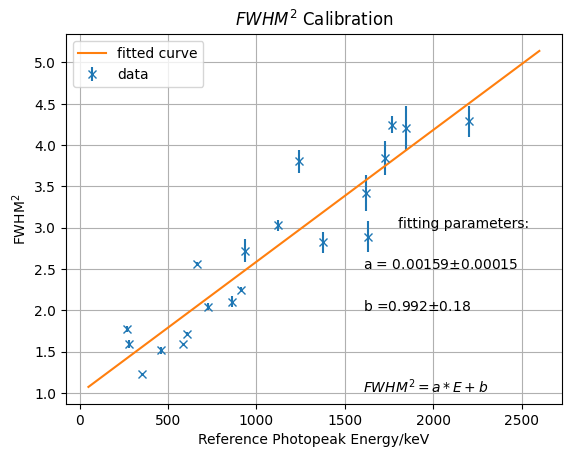

In [19]:
x_plot = np.linspace(50,2600,10000)
y_fwhm2 = cal_df['FWHM']**2
fwhm2_par,fwhm2_cov = np.polyfit(x,y_fwhm2, 1,cov = True)
fwhm2 = np.poly1d(fwhm2_par)
y_fwhm2_err = 2*cal_df['FWHM']*cal_df['FWHM_err']
fwhm2_err = np.sqrt(np.diag(fwhm2_cov))
plt.figure()
plt.title(r'$FWHM^2$ Calibration')
plt.errorbar(x,y_fwhm2,yerr = y_fwhm2_err,fmt = 'x',label = 'data')
plt.plot(x_plot,fwhm2(x_plot), label = 'fitted curve')
plt.ylabel(r'FWHM$^2$')
plt.xlabel('Reference Photopeak Energy/keV')
plt.legend()
plt.text(1800,3,f'fitting parameters:')
plt.text(1600,2.5,f'a = {fwhm2_par[0]:.3g}' + r'$\pm$'+ f'{fwhm2_err[0]:.3g}')
plt.text(1600,2,f'b ={fwhm2_par[1]:.3g}' + r'$\pm$'+ f'{fwhm2_err[1]:.3g}')
#plt.text(1600,1.5,f'c ={p_fwhm2[2]:.3g}' + r'$\pm$'+ f'{p_fwhm2_err[2]:.3g}')
plt.text(1600,1,r'$FWHM^2 = a * E+b$')
plt.grid()

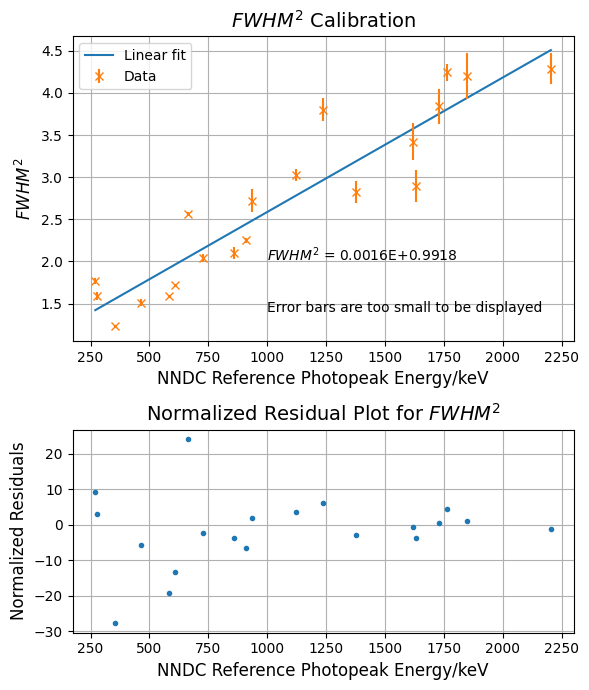

In [20]:
fig_fwhm,ax_fwhm = plt.subplots(2,1,figsize = (6,7), gridspec_kw={'height_ratios': [3, 2]})
ax_fwhm[0].set_title(r'$FWHM^2$ Calibration',fontsize=title_size)
ax_fwhm[0].plot(x,fwhm2(x),label= 'Linear fit')
ax_fwhm[0].errorbar(x,y_fwhm2,yerr= y_fwhm2_err, fmt = 'x',label = 'Data')
ax_fwhm[0].text(1000,2,r'$FWHM^2$'+f' = {fwhm2_par[0]:.4f}E+{fwhm2_par[1]:.4f}')
ax_fwhm[0].text(1000,1.4,'Error bars are too small to be displayed')
ax_fwhm[0].set_xlabel('NNDC Reference Photopeak Energy/keV',fontsize=label_size)
ax_fwhm[0].set_ylabel(r'$FWHM^2$',fontsize=label_size)
ax_fwhm[0].grid()
ax_fwhm[0].legend()
ax_fwhm[1].set_title(r'Normalized Residual Plot for $FWHM^2$',fontsize=title_size)
ax_fwhm[1].plot(x,(y_fwhm2-fwhm2(x))/y_fwhm2_err,'.')
ax_fwhm[1].set_xlabel('NNDC Reference Photopeak Energy/keV',fontsize=label_size)
ax_fwhm[1].set_ylabel('Normalized Residuals',fontsize=label_size)
ax_fwhm[1].grid()
fig_fwhm.tight_layout()
plt.savefig('formal_report_plots/fwhm2_cal.pdf')

In [318]:
chi2_prob(fwhm2(x),y_fwhm2,y_fwhm2_err,len(y)-2)


 chi2: 2194.430996509056 
 reduced chi2: 121.912833139392
 chi2 p-value: 0.0


121.912833139392

In [281]:
fwhm2_par/2.35**2/2.96*1000

array([ 0.09757281, 60.67297654])

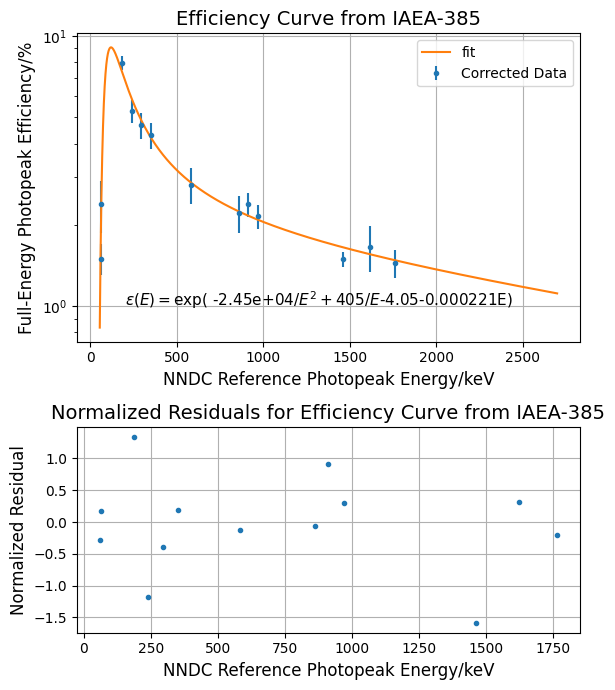

In [21]:
fig, ax = plt.subplots(nrows =2, ncols =1,figsize = (6,7), gridspec_kw={'height_ratios': [3, 2]})

ax[0].set_title('Efficiency Curve from IAEA-385',fontsize = title_size)
ax[0].errorbar(x_eff,100*eff_df['eff'],yerr =100*eff_df['eff_err'], fmt = '.',label = 'Corrected Data')
#ax[0].errorbar(x_eff,100*eff_df['Peak_CPS_BR']/(eff_df['Abs_Activity']*iaea_mass),yerr =100*eff_df['eff_err'], fmt = 'x',label = 'Original Data')
ax[0].plot(np.linspace(55,2700,10000),100*np.exp(eff_fit(np.linspace(55,2700,10000),*eff_par)),label = 'fit')
ax[0].set_xlabel('NNDC Reference Photopeak Energy/keV',fontsize = label_size)
ax[0].set_ylabel('Full-Energy Photopeak Efficiency/%',fontsize = label_size)
#plt.xscale('log')
ax[0].set_yscale('log')
ax[0].legend()
ax[0].grid()
ax[0].text(200,1,r'$\varepsilon (E) = \exp ($'+f' {eff_par[0]:.3g}'+r'$/E^2 + $'
+f'{eff_par[1]:.3g}'+r'$/E $'+f'{eff_par[2]:.3g}'+f'{eff_par[3]:.3g}E)', fontsize = 11)

ax[1].set_title('Normalized Residuals for Efficiency Curve from IAEA-385',fontsize = title_size)
ax[1].plot(x_eff,(eff_df['eff']-np.exp(eff_fit(x_eff,*eff_par)))/eff_df['eff_err'],'.')
ax[1].set_xlabel('NNDC Reference Photopeak Energy/keV',fontsize = label_size)
ax[1].set_ylabel('Normalized Residual',fontsize = label_size)
ax[1].grid()

fig.tight_layout()
plt.savefig('formal_report_plots/eff_cal.pdf')

In [22]:
sample_mass = np.array([0.427-0.0583, 0.5733-0.0576,0.5399-0.0581,0.5585-0.0581 ])
live_time = np.array(Spec(0).live_time)
df['Peak_CPS_BR_corr'] = df['Peak_CPS_BR']-df['Peak_CPS_BR_bg']
df['Peak_CPS_BR_corr_err'] = np.sqrt((df['Peak_CPS_BR']*df['rel_err'])**2
                                    +(df['Peak_CPS_BR_bg']*df['rel_err_bg'])**2)
#pseudo activity per mass        
m_arr_2 = np.concatenate([np.full(len(df.loc[i]),m_arr[i])for i in range(6)]) #mass array compatible with df
df['pseudo_A'] = df['Peak_CPS_BR_corr']/df['eff']/m_arr_2
df['pseudo_A_err'] = df['pseudo_A']*np.sqrt((df['Peak_CPS_BR_corr_err']/df['Peak_CPS_BR_corr'])**2
                                           +(df['eff_err']/df['eff'])**2)
df[df['Nuclide']=='Ra226']['pseudo_A']

1  9     2.928530
2  8     2.581054
3  9     3.043796
4  9     2.730586
5  9    24.773014
Name: pseudo_A, dtype: float64

In [23]:
#print(cal_df[['nndc_peak_energy','Nuclide','Reduced_chi2']].to_latex(index=False))
#print(eff_df[['nndc_peak_energy','Nuclide','BR']].to_latex(index=False))

In [106]:
fit_df = pd.DataFrame({'Calibration':['Param','Param_err','reduced chi^2','cov'],
    'Energy':[E_par,E_err,chi2_prob(E_fit(x),y,y_err,len(x)-2),E_cov],
    'Energy (Lynx)':[[a,b,c],0,chi2_prob(energy_to_chan(x),y,y_err,len(x)-3),0],
    'FWHMM^2':[fwhm2_par,fwhm2_err,chi2_prob(fwhm2(x),y_fwhm2,y_fwhm2_err,len(x)-2),fwhm2_cov],
    'Efficiency' : [eff_par,eff_par_err,chi2_prob(np.exp(eff_fit(x_eff,*eff_par)),eff_df['eff'],eff_df['eff_err'], len(eff_df['eff'])-len(eff_par)),eff_cov]
    })
fit_df.set_index('Calibration',inplace = True)
fit_df_style = fit_df.style.format( precision=3,)
print(fit_df_style.to_latex(column_format = 'c|c|c|c|c'))

 chi2: 1998.30163458905 
 reduced chi2: 111.01675747716945
 chi2 p-value: 0.0
 chi2: 3281.3526423985977 
 reduced chi2: 193.02074367050574
 chi2 p-value: 0.0
 chi2: 2194.430996509056 
 reduced chi2: 121.912833139392
 chi2 p-value: 0.0
 chi2: 7.1186146729641235 
 reduced chi2: 0.7909571858849026
 chi2 p-value: 0.6247713250407927
\begin{tabular}{c|c|c|c|c}
 & Energy & Energy (Lynx) & FWHMM^2 & Efficiency \\
Calibration &  &  &  &  \\
Param & [1.47527259 0.85756689] & [8.387880257e-08, 0.6775230169, -0.3439140022] & [0.00159498 0.99179688] & [-2.44591423e+04  4.04578570e+02 -4.04548974e+00 -2.21065474e-04] \\
Param_err & [9.36143027e-05 1.12643818e-01] & 0 & [1.49885147e-04 1.80353159e-01] & [2.09044357e+03 4.18226030e+01 1.43782120e-01 8.83965742e-05] \\
reduced chi^2 & 111.017 & 193.021 & 121.913 & 0.791 \\
cov & [[ 8.76363767e-09 -9.28206774e-06]
 [-9.28206774e-06  1.26886297e-02]] & 0 & [[ 2.24655573e-08 -2.37945511e-05]
 [-2.37945511e-05  3.25272619e-02]] & [[ 4.36995430e+06 -8.67372

### Re-normalization of Sample 3

Actual activity is not calculated as geometric efficiencies of sample marinelli beaker and IAEA385 bottle are unknown. However, it is assumed that these efficiencies are energy independent, hence not-yet-corrected efficiency calculated can be used to compare activity of different nuclide in samples of the same geometry. This activity is named psuedo activity here.


In [80]:

class nuclide:
    def __init__(self,name):
        self.df = df[df['Nuclide']==name].loc[1:4].reset_index()
        self.cps = self.df['Peak_CPS'] 
        self.cps_err = self.df['Net_Area_err']/live_time[1:5]
        self.name = name
        self.pseudo_A = self.df['pseudo_A']
        self.pseudo_A_err = self.df['pseudo_A_err']
        self.E = self.df['nndc_peak_energy'][0]
    def plot_cps(self):
        plt.figure()
        plt.errorbar(np.arange(1,5,1),self.cps
        ,yerr = self.cps_err ,fmt='.')
        plt.ylabel('Counts per second')
        plt.xlabel('Sample No.')
        plt.title(f'{self.name} Peak Count per Seconds per unit mass')
        plt.xticks(range(1,5))
        #plt.savefig(f'/Plot Images/{name}_cps.pdf')

In [81]:
nuclide('Cs137').E

661.657

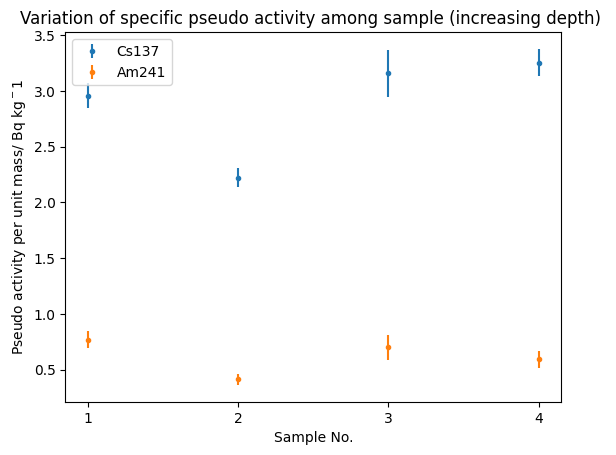

In [29]:
for nuc in ['Cs137','Am241']:
    plt.errorbar(np.arange(1,5,1),nuclide(nuc).pseudo_A
            ,yerr = nuclide(nuc).pseudo_A_err ,fmt='.',label = nuc)
    nuclide('Cs137').pseudo_A
    plt.ylabel(r'Pseudo activity per unit mass/ Bq kg$^-1$')
    plt.xlabel('Sample No.')
    plt.title('Variation of specific pseudo activity among sample (increasing depth) ')
    plt.xticks(range(1,5))
    plt.legend()
    plt.grid()

In [471]:
nuclide('Am241').pseudo_A/nuclide('Cs137').pseudo_A

0    0.248613
1    0.176652
2    0.211228
3    0.173383
Name: pseudo_A, dtype: float64

In [474]:
A_D/17.7

0.2516944018010018

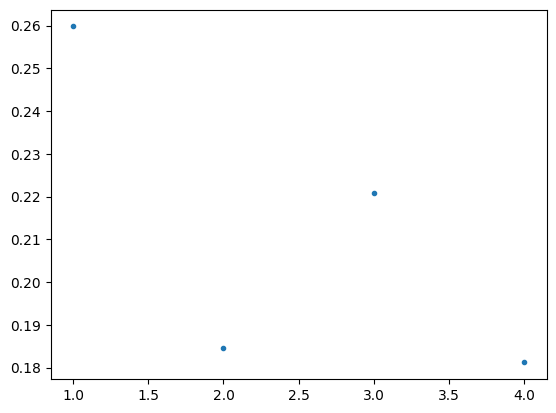

In [30]:
plt.plot(np.arange(1,5),nuclide('Am241').pseudo_A/nuclide('Cs137').pseudo_A,'.')

In [466]:
df[df['nndc_peak_energy'] == 186.211]

,,Photopeak_Energy,Centroid,Nuclide,Net_Area_Count,Net_Area_err,Peak_CPS,FWHM,Reduced_chi2,rounded_energy,nuc,...,Peak_CPS_BR,rel_err,Peak_CPS_BR_bg,rel_err_bg,eff,eff_err,Peak_CPS_BR_corr,Peak_CPS_BR_corr_err,pseudo_A,pseudo_A_err
1,9,186.21,186.34,Ra226,2959.600000,138.400000,0.002870,1.24,1.43,186.0,Ra226,...,0.138093,0.046763,0.0,0.0,0.07285,0.003913,0.138093,0.006458,1.782411,0.134129
2,8,186.21,185.97,Ra226,4284.900000,145.100000,0.003530,1.13,1.14,186.0,Ra226,...,0.169819,0.033863,0.0,0.0,0.07285,0.003913,0.169819,0.005751,2.191898,0.149028
3,9,186.21,186.38,Ra226,4048.560927,299.296844,0.003889,1.20,1.01,186.0,Ra226,...,0.187100,0.073927,0.0,0.0,0.07285,0.003913,0.187100,0.013832,2.414953,0.228352
4,9,186.21,186.37,Ra226,3337.000000,144.400000,0.003623,1.33,1.10,186.0,Ra226,...,0.174327,0.043272,0.0,0.0,0.07285,0.003913,0.174327,0.007544,2.250088,0.164556
5,9,186.21,185.97,Ra226,6877.100000,177.900000,0.003285,1.13,1.28,186.0,Ra226,...,0.158030,0.025868,0.0,0.0,0.07285,0.003913,0.158030,0.004088,2.039741,0.131324


In [218]:
np.sort(df['nndc_peak_energy'].unique())

array([  59.5409,   63.29  ,   74.815 ,   77.107 ,   89.807 ,   92.8   ,
        100.41  ,  106.17  ,  129.065 ,  153.977 ,  186.211 ,  209.253 ,
        238.632 ,  242.47  ,  270.245 ,  277.371 ,  295.224 ,  300.087 ,
        328.    ,  332.37  ,  338.32  ,  351.932 ,  409.462 ,  463.004 ,
        583.187 ,  609.321 ,  661.657 ,  665.446 ,  727.33  ,  755.315 ,
        768.36  ,  772.3279,  786.39  ,  794.947 ,  803.06  ,  835.71  ,
        840.377 ,  860.557 ,  911.204 ,  934.5   ,  964.766 ,  968.971 ,
       1001.03  , 1120.294 , 1155.21  , 1238.122 , 1280.976 , 1377.669 ,
       1385.31  , 1401.515 , 1407.988 , 1460.82  , 1509.211 , 1588.2   ,
       1620.5   , 1630.627 , 1661.274 , 1729.595 , 1764.491 , 1847.433 ,
       2118.513 , 2204.1   , 2447.69  , 2614.511 ])

In [40]:
df.loc[1:][df.loc[1:,'nndc_peak_energy'].isin(U238_E)]

Photopeak_Energy  Centroid Nuclide  Net_Area_Count  Net_Area_err  \
1 1              63.29     63.53   Th234      305.000000     77.100000   
  9             186.21    186.34   Ra226     2959.600000    138.400000   
  15            295.24    295.61   Pb214     6301.600000    121.600000   
  19            351.93    352.44   Pb214    11260.100000    133.600000   
  38           1000.99   1002.11  Pa234m      241.800000     43.200000   
  52           1764.49   1765.44   Bi214     1966.300000     49.100000   
2 1              63.29     63.16   Th234      501.400000    161.500000   
  8             186.21    185.97   Ra226     4284.900000    145.100000   
  14            295.24    295.20   Pb214     9735.000000    144.400000   
  18            351.93    352.01   Pb214    17112.100000    158.300000   
  36           1000.99   1000.47  Pa234m      147.200000     53.300000   
  52           1764.49   1764.56   Bi214     2711.600000     58.400000   
3 1              63.29     63.76   Th234      484.003036    140.822184   
  9             186.21    186.38   Ra226     4048.560927    299.296844   
  15            295.24    295.66   Pb214     8391.856329    485.940396   
  19            351.93    352.48   Pb214    14678.765021    823.783011   
  39           1000.99   1001.37  Pa234m      153.543170     46.177938   
  53           1764.49   1765.60   Bi214     2351.984914    148.103304   
4 1              63.29     63.77   Th234      467.900000     97.900000   
  9             186.21    186.37   Ra226     3337.000000    144.400000   
  15            295.24    295.66   Pb214     7783.200000    128.600000   
  19            351.93    352.49   Pb214    13745.800000    141.400000   
  39           1000.99   1001.93  Pa234m      168.000000     46.200000   
  53           1764.49   1765.63   Bi214     2191.900000     52.600000   
5 1              63.29     63.44   Th234     1518.500000    143.200000   
  9             186.21    185.97   Ra226     6877.100000    177.900000   
  15            295.24    295.24   Pb214    13121.300000    171.200000   
  20            351.93    352.04   Pb214    22888.500000    186.600000   
  41           1000.99   1001.09  Pa234m      311.500000     56.900000   
  55           1764.49   1764.65   Bi214     3455.500000     67.800000   

      Peak_CPS  FWHM  Reduced_chi2  rounded_energy    nuc  ...   rel_err  \
1 1   0.000518  0.87          1.05            63.0  Th234  ...  0.252787   
  9   0.002870  1.24          1.43           186.0  Ra226  ...  0.046763   
  15  0.010703  1.03          2.83           295.0  Pb214  ...  0.019297   
  19  0.019124  1.15          1.58           352.0  Pb214  ...  0.011865   
  38  0.000411  1.87          0.50          1001.0  Pa234  ...  0.178660   
  52  0.003340  2.17          1.16          1764.0  Bi214  ...  0.024971   
2 1   0.000723  1.19          0.95            63.0  Th234  ...  0.322098   
  8   0.003530  1.13          1.14           186.0  Ra226  ...  0.033863   
  14  0.014044  1.00          1.04           295.0  Pb214  ...  0.014833   
  18  0.024686  1.08          0.93           352.0  Pb214  ...  0.009251   
  36  0.000212  1.85          1.59          1001.0  Pa234  ...  0.362092   
  52  0.003912  2.13          1.41          1764.0  Bi214  ...  0.021537   
3 1   0.000814  0.57          0.71            63.0  Th234  ...  0.290953   
  9   0.003889  1.20          1.01           186.0  Ra226  ...  0.073927   
  15  0.014116  1.05          0.77           295.0  Pb214  ...  0.057906   
  19  0.024692  1.12          1.33           352.0  Pb214  ...  0.056121   
  39  0.000258  1.04          1.70          1001.0  Pa234  ...  0.300749   
  53  0.003956  2.15          0.78          1764.0  Bi214  ...  0.062969   
4 1   0.000890  0.96          1.36            63.0  Th234  ...  0.209233   
  9   0.003623  1.33          1.10           186.0  Ra226  ...  0.043272   
  15  0.014800  1.04          3.46           295.0  Pb214  ...  0.016523   
  19  0.026139  1.09          0.92     

Text(0, 0.5, 'Pseudo Activity per mass/ Bq kg$^{-1}$')

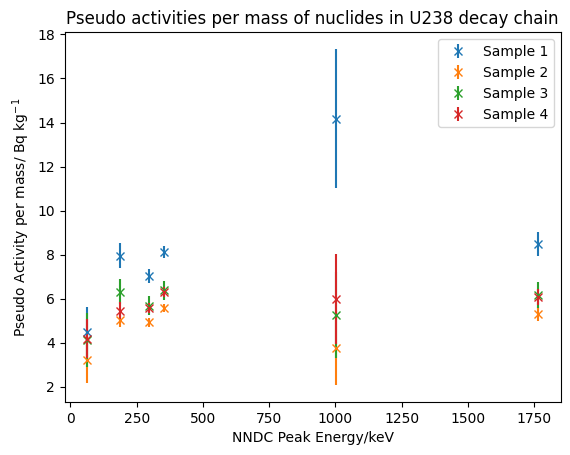

In [42]:
class chain:
    def __init__(self,E_arr):
        '''Output section of dataframe only with energies present in the E_arr'''
        self.df = df.loc[1:][df.loc[1:,'nndc_peak_energy'].isin(E_arr)]
        self.nuc = self.df['nuclide']
    
U238_df = df[df['nndc_peak_energy'].isin(U238_E)]
chain(U238_E).df
plt.figure()
plt.title('Pseudo activities per mass of nuclides in U238 decay chain')
for i in range(4):
    plt.errorbar(U238_df.loc[i+1]['nndc_peak_energy'],U238_df.loc[i+1]['pseudo_A']/sample_mass[i]*np.array([1,1,1/1.051,1/0.996,1/1.231,1]),
    yerr= U238_df.loc[i+1]['pseudo_A_err']/sample_mass[i], fmt = 'x', label = f'Sample {i+1}')
    plt.legend()
plt.xlabel('NNDC Peak Energy/keV')
plt.ylabel(r'Pseudo Activity per mass/ Bq kg$^{-1}$')

In [55]:
idx = chain(U238_E).df[chain(U238_E).df['nndc_peak_energy']==U238_E[2]].index
nuc = 

MultiIndex([(1, 9),
            (2, 8),
            (3, 9),
            (4, 9),
            (5, 9)],
           )

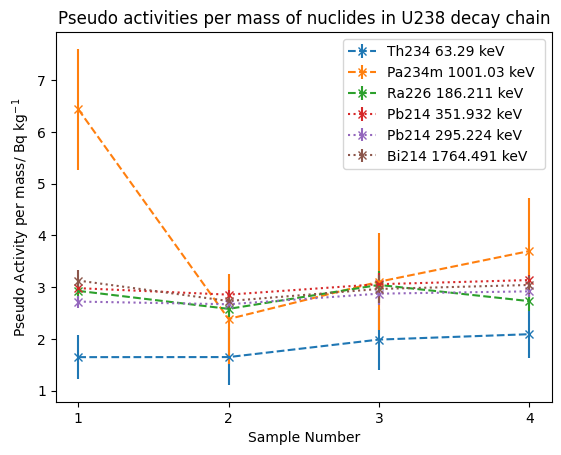

In [87]:
plt.title('Pseudo activities per mass of nuclides in U238 decay chain')
marker = ['x--', 'x--', 'x--', 'x:', 'x:', 'x:']
for i in range(len(U238_E)):
    E = U238_E[i]
    idx = chain(U238_E).df[chain(U238_E).df['nndc_peak_energy']==U238_E[i]].index
    nuc = chain(U238_E).df.loc[idx[0],'Nuclide']
    plt.errorbar(np.arange(1,5),chain(U238_E).df.loc[idx,'pseudo_A'][:-1], 
    yerr= chain(U238_E).df.loc[idx,'pseudo_A_err'][:-1],
     fmt =marker[i],label = f'{nuc} {E} keV ')
    #plt.errorbar(np.arange(1,5),chain(U238_E).df.loc[idx,'pseudo_A'][:-1])
plt.legend()
plt.xticks(np.arange(1,5))
plt.xlabel('Sample Number')
plt.ylabel(r'Pseudo Activity per mass/ Bq kg$^{-1}$')
plt.savefig('formal_report_plots/U238.pdf')

Text(0, 0.5, 'Pseudo Activity per mass/ Bq kg$^{-1}$')

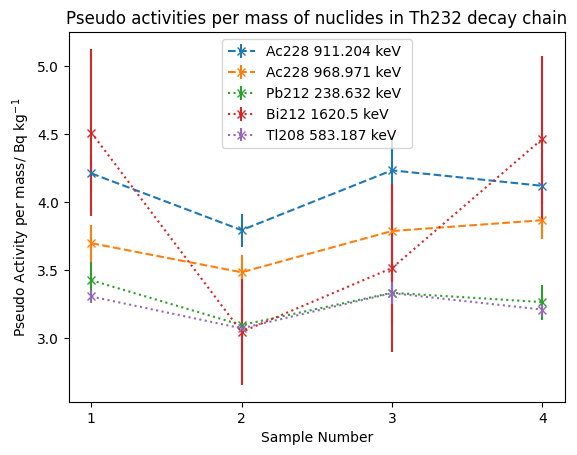

In [102]:
plt.title('Pseudo activities per mass of nuclides in Th232 decay chain')
marker = ['x--', 'x--', 'x:', 'x:', 'x:', 'x:']
Th232_scale = [1/0.887,1/0.905,1,1,1/0.3594] #rescale for branching ratio of Tl208 to give th232 equivalent
for i in range(len(Th232_E)-1):
    E = Th232_E[i]
    
    idx = chain(Th232_E).df[chain(Th232_E).df['nndc_peak_energy']==Th232_E[i]].index
    nuc = chain(Th232_E).df.loc[idx[0],'Nuclide']
    plt.errorbar(np.arange(1,5),chain(Th232_E).df.loc[idx,'pseudo_A'][:-1]*Th232_scale[i], 
    yerr= chain(Th232_E).df.loc[idx,'pseudo_A_err'][:-1],
     fmt =marker[i],label = f'{nuc} {E} keV ')
    #plt.errorbar(np.arange(1,5),chain(U238_E).df.loc[idx,'pseudo_A'][:-1])
plt.legend()
plt.xticks(np.arange(1,5))
plt.xlabel('Sample Number')
plt.ylabel(r'Pseudo Activity per mass/ Bq kg$^{-1}$')
#plt.savefig('formal_report_plots/Th232.pdf')

In [78]:
eff_df['nndc_peak_energy'].unique()

array([  59.5409,   63.29  ,  911.204 ,  968.971 ,  186.211 ,  238.632 ,
        295.224 ,  351.932 ,  583.187 ,  860.557 , 1764.491 , 1620.5   ,
       1460.82  ])

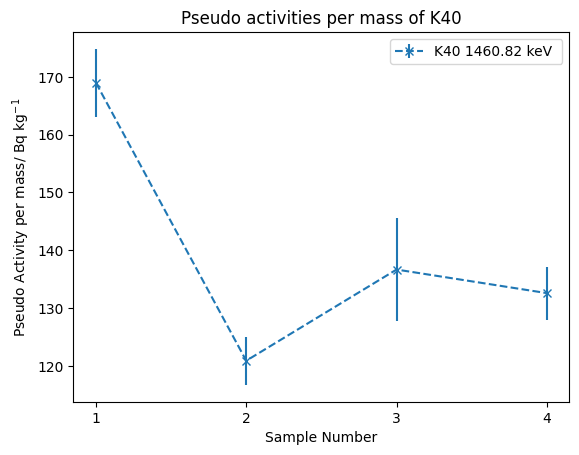

In [91]:
plt.title('Pseudo activities per mass of K40')
marker = ['x--', 'x--', 'x--', 'x:', 'x:', 'x:']
K40_E = [1460.82]
for i in range(len(K40_E)):
    E = K40_E[i]
    idx = chain(K40_E).df[chain(K40_E).df['nndc_peak_energy']==K40_E[i]].index
    nuc = chain(K40_E).df.loc[idx[0],'Nuclide']
    plt.errorbar(np.arange(1,5),chain(K40_E).df.loc[idx,'pseudo_A'][:-1], 
    yerr= chain(K40_E).df.loc[idx,'pseudo_A_err'][:-1],
     fmt =marker[i],label = f'{nuc} {E} keV ')
    #plt.errorbar(np.arange(1,5),chain(U238_E).df.loc[idx,'pseudo_A'][:-1])
plt.legend()
plt.xticks(np.arange(1,5))
plt.xlabel('Sample Number')
plt.ylabel(r'Pseudo Activity per mass/ Bq kg$^{-1}$')
plt.savefig('formal_report_plots/K40.pdf')

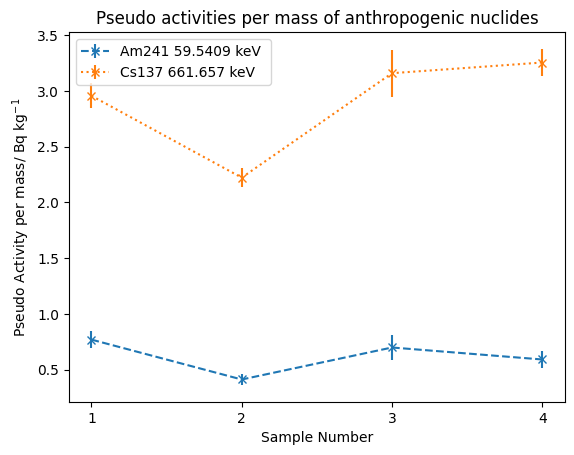

In [92]:
plt.title('Pseudo activities per mass of anthropogenic nuclides')
marker = ['x--', 'x:', 'x--', 'x:', 'x:', 'x:']
Am_Cs_E = [59.5409, 661.657]
for i in range(len(Am_Cs_E)):
    E = Am_Cs_E[i]
    idx = chain(Am_Cs_E).df[chain(Am_Cs_E).df['nndc_peak_energy']==Am_Cs_E[i]].index
    nuc = chain(Am_Cs_E).df.loc[idx[0],'Nuclide']
    plt.errorbar(np.arange(1,5),chain(Am_Cs_E).df.loc[idx,'pseudo_A'][:-1], 
    yerr= chain(Am_Cs_E).df.loc[idx,'pseudo_A_err'][:-1],
     fmt =marker[i],label = f'{nuc} {E} keV ')
    #plt.errorbar(np.arange(1,5),chain(U238_E).df.loc[idx,'pseudo_A'][:-1])
plt.legend()
plt.xticks(np.arange(1,5))
plt.xlabel('Sample Number')
plt.ylabel(r'Pseudo Activity per mass/ Bq kg$^{-1}$')
plt.savefig('formal_report_plots/Cs137_Am241.pdf')

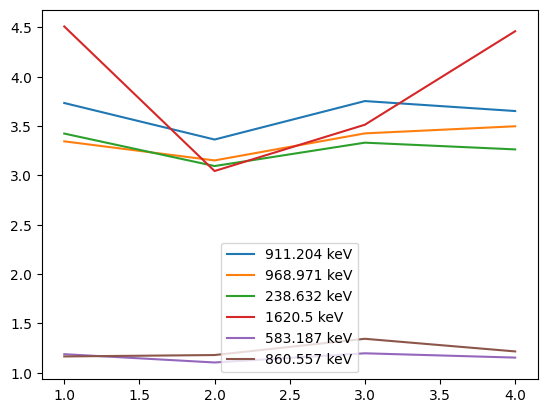

In [47]:
for E in Th232_E:
    plt.plot(np.arange(1,5),chain(Th232_E).df[chain(Th232_E).df['nndc_peak_energy']==E]['pseudo_A'][:-1]
    ,label = f'{E} keV {}')
    plt.legend()

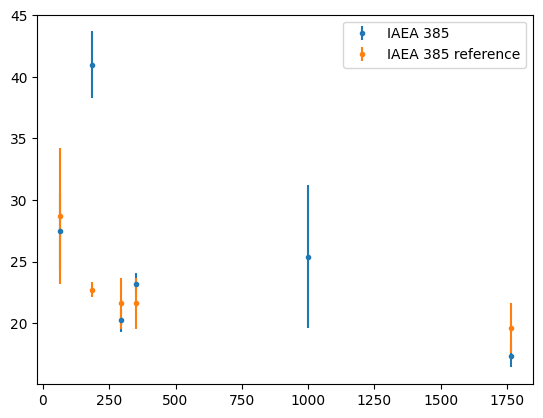

In [496]:
plt.figure()
U238_df2 = eff_df[eff_df['nndc_peak_energy'].isin(U238_E)]
plt.errorbar(U238_df.loc[5]['nndc_peak_energy'],U238_df.loc[5]['pseudo_A']/0.05*np.array([1,0.999,1/1.051,1/0.996,1/1.231,1]),
    yerr= U238_df.loc[5]['pseudo_A_err']/0.05, fmt = '.', label = f'IAEA 385')
plt.errorbar(U238_df2['nndc_peak_energy'],U238_df2['Abs_Activity'],
    yerr= U238_df2['Abs_Activity_Unc'], fmt = '.', label = f'IAEA 385 reference')
plt.legend()

In [ ]:
df['nndc_peak_energy']==

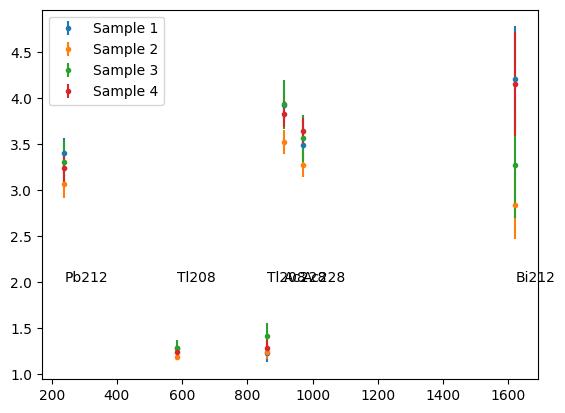

In [324]:
Th232_df = df[df['nndc_peak_energy'].isin(Th232_E)]
for i in range(4):
    plt.errorbar(Th232_df.loc[i+1]['nndc_peak_energy'],Th232_df.loc[i+1]['pseudo_A']/sample_mass[i],
    yerr= Th232_df.loc[i+1]['pseudo_A_err']/sample_mass[i], fmt = '.', label = f'Sample {i+1}')
    plt.legend()
for index, row in Th232_df.loc[i+1].iterrows():
    plt.text(row['nndc_peak_energy'],2,row['Nuclide'])

In [222]:
eff_df['nndc_peak_energy'].unique()

array([  63.29 ,  911.204,  968.971,  186.211,  238.632,  295.224,
        351.932,  583.187,  860.557, 1764.491, 1620.5  , 1460.82 ])

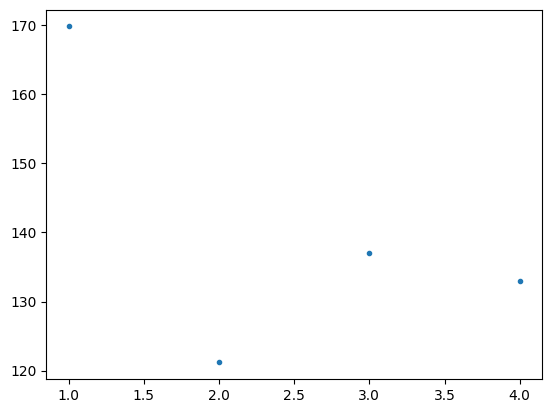

In [229]:
plt.plot(np.arange(1,5),df[df['nndc_peak_energy']==1460.82]['pseudo_A'][1:5]/sample_mass,'.')


In [101]:
print(eff_df[['Nuclide','Abs_Activity','Abs_Activity_Unc']].to_latex(index=False))

\begin{tabular}{lrr}
\toprule
Nuclide &  Abs\_Activity &  Abs\_Activity\_Unc \\
\midrule
  Am241 &          4.45 &              0.23 \\
  Th234 &         28.70 &              5.50 \\
  Ac228 &         31.50 &              2.72 \\
  Ac228 &         31.50 &              2.72 \\
  Ra226 &         22.70 &              0.60 \\
  Pb212 &         37.30 &              3.14 \\
  Pb214 &         21.60 &              2.08 \\
  Pb214 &         21.60 &              2.08 \\
  Tl208 &         11.60 &              1.67 \\
  Tl208 &         11.60 &              1.67 \\
  Bi214 &         19.60 &              2.01 \\
  Bi212 &         34.20 &              5.92 \\
    K40 &        611.00 &             27.00 \\
\bottomrule
\end{tabular}



/var/folders/vh/bwtbn9cn1xlbm74kxlygt5b80000gn/T/ipykernel_70491/2018088936.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(eff_df[['Nuclide','Abs_Activity','Abs_Activity_Unc']].to_latex(index=False))


In [97]:
iaea_latex = iaea_385[iaea_385['Nuclide'].isin(['U238','Th234','Ra226','Pb214','Bi214','Th232','Ac228','Pb212','Bi212','Tl208'])]


,Nuclide,Abs_Activity,Abs_Activity_Unc
2,Ra226,22.7,0.60
5,Th232,33.8,0.90
7,U238,29.4,1.20
20,Ac228,31.5,2.72
21,Pb214,21.6,2.08
22,Bi214,19.6,2.01
23,Pb212,37.3,3.14
24,Bi212,34.2,5.92
25,Tl208,11.6,1.67
26,Th234,28.7,5.50


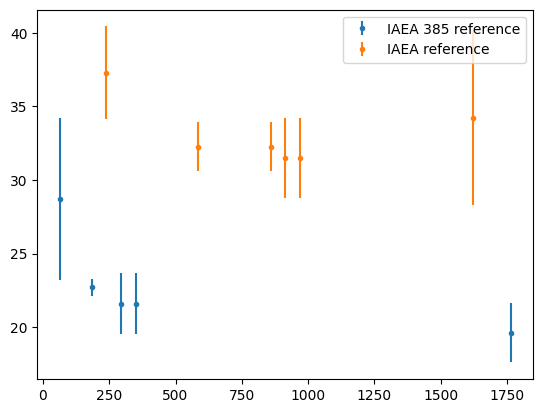

In [72]:
plt.figure()
U238_df2 = eff_df[eff_df['nndc_peak_energy'].isin(U238_E)]
Th232_df2 = eff_df[eff_df['nndc_peak_energy'].isin(Th232_E)]
plt.errorbar(U238_df2['nndc_peak_energy'],U238_df2['Abs_Activity'],
    yerr= U238_df2['Abs_Activity_Unc'], fmt = '.', label = f'IAEA 385 reference')
plt.errorbar(Th232_df2['nndc_peak_energy'],Th232_df2['Abs_Activity']*np.array([1,1,1,1/0.3594,1/0.3594,1]),
    yerr= Th232_df2['Abs_Activity_Unc'], fmt = 'x', label = f'IAEA reference')
plt.legend()
# for index, row in Th232_df.loc[i+1].iterrows():
#     plt.text(row['nndc_peak_energy'],2,row['Nuclide'])

In [325]:
Th232_df2[['nndc_peak_energy','eff']]

,nndc_peak_energy,eff
18,911.204,0.023829
20,968.971,0.021533
24,238.632,0.052789
30,583.187,0.028118
31,860.557,0.022200
53,1620.500,0.016608


In [326]:
Th232_df.loc[5][['nndc_peak_energy','eff']]

,nndc_peak_energy,eff
11,238.632,0.059382
23,583.187,0.026637
36,860.557,0.021242
37,911.204,0.020664
40,968.971,0.020090
51,1620.500,0.016709


In [125]:
11.6/0.3594

32.27601558152476

In [92]:
Th232_df

Photopeak_Energy  Centroid Nuclide  Net_Area_Count  Net_Area_err  \
1 11            238.63    239.02   Pb212    19128.600000    168.400000   
  22            583.19    583.71   Tl208     6295.100000     97.900000   
  34            860.56    861.24   Tl208      709.800000     55.900000   
  35            911.20    911.84   Ac228     4540.800000     84.100000   
  38            968.97    969.53   Ac228     2333.000000     69.400000   
  49           1620.50   1621.53   Bi212      224.400000     29.100000   
2 10            238.63    238.61   Pb212    28402.300000    199.700000   
  21            583.19    583.21   Tl208     9609.200000    117.300000   
  31            860.56    860.64   Tl208     1180.400000     60.400000   
  32            911.20    911.27   Ac228     6719.500000     98.700000   
  35            968.97    968.97   Ac228     3720.300000     87.900000   
  48           1620.50   1620.76   Bi212      248.900000     30.100000   
3 11            238.63    239.04   Pb212    24498.876873   1356.957893   
  22            583.19    583.76   Tl208     8347.959705    478.122680   
  34            860.56    861.30   Tl208     1077.842646     98.409434   
  35            911.20    911.92   Ac228     6008.136626    351.265344   
  38            968.97    969.62   Ac228     3239.988913    206.518313   
  49           1620.50   1621.55   Bi212      230.124726     39.111490   
4 11            238.63    239.05   Pb212    22047.400000    176.600000   
  22            583.19    583.80   Tl208     7391.000000    102.800000   
  34            860.56    861.38   Tl208      896.000000     54.200000   
  35            911.20    911.98   Ac228     5371.100000     89.100000   
  38            968.97    969.70   Ac228     3039.400000     71.300000   
  49           1620.50   1621.83   Bi212      268.500000     35.000000   
5 11            238.63    238.68   Pb212    51318.900000    259.200000   
  23            583.19    583.20   Tl208    16573.000000    149.500000   
  36            860.56    860.62   Tl208     1924.200000     71.500000   
  37            911.20    911.21   Ac228    11576.300000    123.800000   
  40            968.97    968.91   Ac228     6406.400000    108.000000   
  51           1620.50   1620.77   Bi212      499.100000     39.300000   

      Peak_CPS  FWHM  Reduced_chi2  rounded_energy    nuc  ...   T1/2(s)  \
1 11  0.032488  0.98          7.07           239.0  Pb212  ...  38239.20   
  22  0.010692  1.29          1.58           583.0  Tl208  ...    183.18   
  34  0.001206  1.50          1.46           861.0  Tl208  ...    183.18   
  35  0.007712  1.52          1.45           911.0  Ac228  ...  22140.00   
  38  0.003962  1.49         18.68           969.0  Ac228  ...  22140.00   
  49  0.000381  2.09          1.06          1620.0  Bi212  ...   3633.00   
2 10  0.040973  0.99          8.17           239.0  Pb212  ...  38239.20   
  21  0.013862  1.29          1.87           583.0  Tl208  ...    183.18   
  31  0.001703  1.45          0.86           861.0  Tl208  ...    183.18   
  32  0.009694  1.51          1.93           911.0  Ac228  ...  22140.00   
  35  0.005367  1.44          8.41           969.0  Ac228  ...  22140.00   
  48  0.000359  1.66          2.00          1620.0  Bi212  ...   3633.00   
3 11  0.041212  1.01          3.18           239.0  Pb212  ...  38239.20   
  22  0.014042  1.21          1.65           583.0  Tl208  ...    183.18   
  34  0.001813  1.51          1.53           861.0  Tl208  ...    183.18   
  35  0.010106  1.51          1.54           911.0  Ac228  ...  22140.00   
  38  0.005450  1.51         15.07           969.0  Ac228  ...  22140.00   
  49  0.000387  1.70          2.13          1620.0  Bi212  ...   3633.00   
4 11  0.041925  0.98          4.77           239.0  Pb212  ...  38239.20   
  22  0.014054  1.23          1.78           583.0  Tl208  ...    183.18   
  34  0.001704  1.41          1.24           861.0  Tl208  ...    183.18   
  35  0.010214  1.54          2.69     

In [31]:
U238_df['Peak_CPS_BR_corr']/np.exp(eff_fit(U238_df['nndc_peak_energy'],*eff_par))

0  1     0.000000
   2     0.000000
   15    0.000000
1  1     0.578500
   9     1.415348
   15    0.889391
   19    1.027772
   39         NaN
   53    1.105293
2  1     0.807817
   8     1.740506
   14    1.217402
   18    1.373990
   36         NaN
   52    1.347290
3  1     0.909243
   9     1.917626
   15    1.224480
   19    1.374384
   39         NaN
   53    1.366151
4  1     0.993693
   9     1.786712
   15    1.291625
   19    1.464435
   39         NaN
   53    1.455643
5  1     1.418333
   9     1.619684
   15    0.916095
   20    1.029079
   41         NaN
   55    0.915274
Name: Peak_CPS_BR_corr, dtype: float64

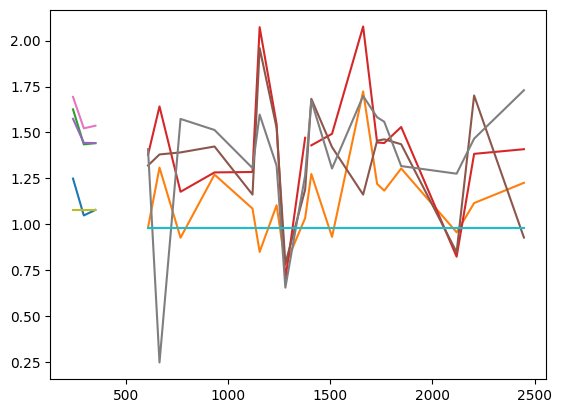

In [123]:
for i in range(5):
    pb214 = df[df['Nuclide']=='Pb214'].loc[i+1]
    bi214 = df[df['Nuclide']=='Bi214'].loc[i+1]
    plt.plot(pb214['nndc_peak_energy'],pb214['pseudo_A'])
    plt.plot(bi214['nndc_peak_energy'],bi214['pseudo_A'])

In [124]:
bi214[['nndc_peak_energy','Peak_CPS_BR_corr','BR']]

,nndc_peak_energy,Peak_CPS_BR_corr,BR
24,609.321,0.026807,0.45440
26,665.446,0.025584,0.01540
29,768.360,0.022709,0.04889
38,934.500,0.018648,0.03094
42,1120.294,0.019018,0.14900
43,1155.210,0.021335,0.01634
44,1238.122,0.016942,0.05830
45,1280.976,0.026372,0.01435
46,1377.669,0.017918,0.03985
47,1407.988,0.010820,0.02388


In [489]:
bg_df

,Photopeak_Energy,Centroid,Nuclide,Net_Area_Count,Net_Area_err,Peak_CPS,FWHM,Reduced_chi2,rounded_energy,nuc,...,E_err,BR,BR_err,T1/2(s),Centroid_err,FWHM_err,Resolution,Resolution_err,Peak_CPS_BR,rel_err
0,242.00,242.44,Pb214,405.1,80.4,0.000981,1.36,3.69,242.0,Pb214,...,0.04,0.072600,3e-05,1.623600e+03,0.028695,0.047780,0.005610,0.000197,0.013508,0.198470
1,295.24,295.59,Pb214,679.2,62.6,0.001644,1.20,1.71,295.0,Pb214,...,0.002,0.184700,5e-05,1.623600e+03,0.019554,0.032559,0.004060,0.000110,0.008901,0.092167
2,351.93,352.43,Pb214,1079.4,56.5,0.002613,1.19,1.72,352.0,Pb214,...,0.0021,0.357200,9e-05,1.623600e+03,0.015381,0.025612,0.003377,0.000073,0.007315,0.052344
3,609.31,609.84,Bi214,832.3,41.3,0.002015,1.33,3.09,609.0,Bi214,...,0.007,0.454400,,1.182600e+03,0.019577,0.032598,0.002181,0.000053,0.004434,0.049622
4,768.36,769.08,Bi214,59.4,20.9,0.000144,1.00,0.85,768.0,Bi214,...,0.007,0.048890,0.03E-5,1.182600e+03,0.055100,0.091747,0.001300,0.000119,0.002942,0.351852
5,803.06,803.55,Pb206m,171.0,31.7,0.000414,1.61,1.89,803.0,Pb206,...,0.03,0.980002,7,1.250000e-04,0.052284,0.087059,0.002004,0.000108,0.000422,0.185380
6,934.06,934.63,Bi214,43.4,16.2,0.000105,1.16,0.62,934.0,Bi214,...,0.5,0.030940,0.16E-5,1.182600e+03,0.074775,0.124508,0.001241,0.000133,0.003393,0.373272
7,1120.29,1120.78,Bi214,173.2,23.3,0.000419,1.59,1.66,1120.0,Bi214,...,0.006,0.149000,0.4E-5,1.182600e+03,0.051306,0.085430,0.001419,0.000076,0.002814,0.134527
8,1238.11,1238.63,Bi214,126.2,38.8,0.000306,2.71,0.84,1238.0,Bi214,...,0.01,0.058300,0.03,1.182600e+03,0.102443,0.170579,0.002188,0.000138,0.005241,0.307448
9,1377.67,1378.41,Bi214,47.9,16.0,0.000116,1.21,0.93,1378.0,Bi214,...,0.012,0.039850,0.06E-6,1.182600e+03,0.074244,0.123624,0.000878,0.000090,0.002911,0.334029
